## SSAC - Exploration 14 - class imbalance : xray classification

---
# 프로젝트 : 폐렴 진단기 성능개선

좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.
## Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.


In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/ssac7/aiffel


In [3]:
# 데이터 이름 가져오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# 데이터 불러와서 train val 나누기
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 이미지 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1056
Pneumonia images count in training set: 3129


In [6]:
#tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 리벨 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
# 라벨데이터 만들기
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
# 이미지 사이즈 줄이기
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# 트레인 데이터셋, 벨리데이션 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 라벨 들어간 것 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# 테스트 데이터 셋 만들고 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


---
## Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [14]:
# 좌우 반전 없는 데이터 셋 만들기
def prepare_for_training(ds, shuffle_buffer_size=1000):

    # ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_orig = prepare_for_training(train_ds)
val_ds_orig = prepare_for_training(val_ds)

In [15]:
# 좌우 반전 데이터셋 만들기
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    # ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)

+ tensorflow 2.3 이상에서는 tf.dataset 사이즈를 확인할 수 있다고 하는데 2.2.0 버전에서는 사이즈를 확인할 방법이 따로 없는 것 같아. 좌우 반전 후 사이즈 변화가 있는지는 모르겠다. 

## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.


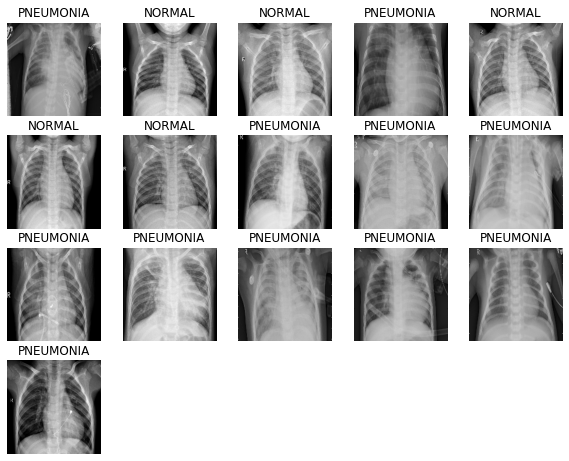

In [30]:
# 사진 좌우 반전 없는 데이터 시각화 첫번째 배치 확인
image_batch, label_batch = next(iter(train_ds_orig))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

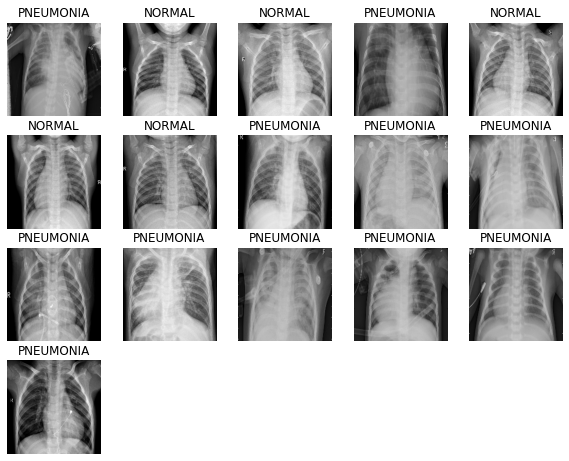

In [31]:
# 좌우 반전한 데이터 시각화 첫번째 배치 확인
image_batch, label_batch = next(iter(train_ds_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

+ 왼쪽 위 부터 사진 위치를 셌을 때 다섯번째, 여섯번째, 아홉번째, 열번째, 열두번째, 열세번째, 열네번째, 열다섯번째 사진이 좌우 반전이 되어 있다.
+ 셔플 없이 좌우반전을 적용했는데 동일한 인덱스에서 임의의 사진이 좌우반전된 것을 확인할 수 있는 것에서 미루어보면 좌우 반전한 사진을 데이터 셋에 추가하는 식으로 작동하는 것은 아닌 것 같다.
+ 원 사진을 좌우 반전 사진으로 대체하는 것이라면 데이터 양에서는 변화가 없을 것이다. 일반화 측면에서는 효과가 있을 수는 있겠지만 좌우 대칭 형태이며 촬영 방향이 정해져 있는 폐 엑스레이 사진에서 좌우 반전이 큰 의미가 있을지는 모르겠다.

In [16]:
# cnn 모델링
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

# dense 모델링 dropout, batchnormalization 모두 사용
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [33]:
# 모델 만들기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [34]:
# 데이터 imbalance 처리 클래스 불균형
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [35]:
# 모델 훈련, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
# model fit : 좌우 반전 없는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_orig,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_orig,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0
    )

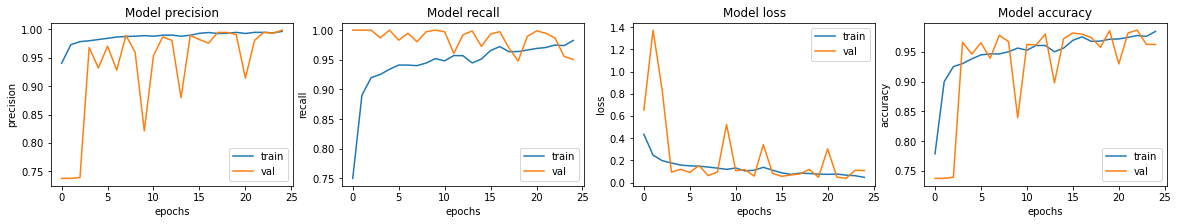

In [37]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
# 테스트 데이터 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 65ms/step - loss: 0.7090 - accuracy: 0.8702 - precision: 0.8396 - recall: 0.9795


+ 87%의 우수한 accuracy와 97%의 우수한 recall을 달성했다.

In [39]:
# 모델 훈련, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
# model fit : 좌우 반전 있는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0
    )

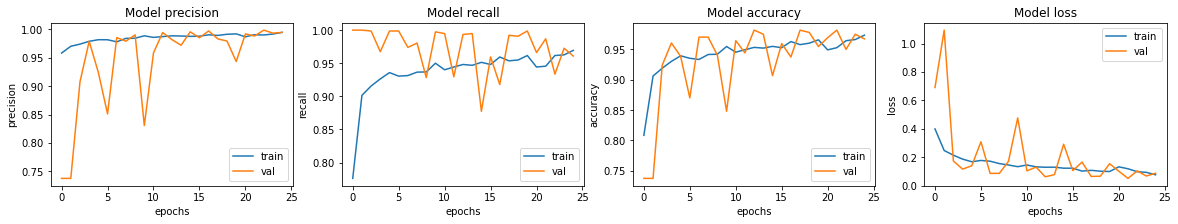

In [41]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
# 테스트 데이터 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 73ms/step - loss: 0.8672 - accuracy: 0.8157 - precision: 0.7823 - recall: 0.9769


In [43]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

+ 폐 사진이라서 좌우 반전을 랜덤으로 적용하하는 것만으로는 학습결과에 큰 영향을 미치지는 않는것 같다.
+ 오히려 좌우반전 모델의 accuracy가 낮은 경우가 많이 나왔다.
+ 데이터 총 수도 동일하여서 유의미한 차이가 없는 것으로 보인다.
+ 아래에서는 좌우 반전 없는 데이터를 섞어서 사용하기로 한다.

In [44]:
# 좌우 반전 없는 데이터 셋 만들기
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [52]:
# cnn 모델링
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

# dense 모델링 batchnormalization만 사용
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [53]:
# 모델 만들기 : global average pooling 
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [54]:
# 데이터 imbalance 처리 클래스 불균형
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [55]:
# 모델 훈련, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [56]:
# model fit : 좌우 반전 없는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0
    )

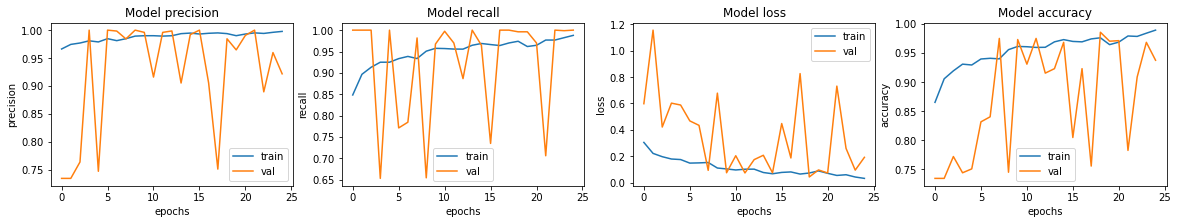

In [57]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

+ 왠지 validataion recall, loss, accuracy, precision이 수렴하는 것 같은 모습을 보이므로 epoch를 더 돌려 보기로 한다.

In [60]:
# 새 모델 만들기, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
# model fit : epoch 30
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=35,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0
    )

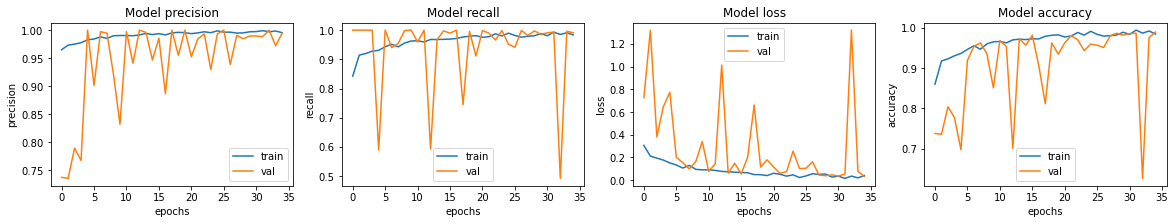

In [62]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
# 테스트 데이터 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 74ms/step - loss: 1.2174 - accuracy: 0.7724 - precision: 0.7375 - recall: 0.9872


In [64]:
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_40 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_41 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_42 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_16 (Dropout)         (None, 11, 11, 128)     

+ 원 모델과 특별히 좋은 결과를 내지는 않았다. 
+ 파라미터가 적으므로 이 모델로 학습을 진행하기로 한다.

## Step 5. 데이터 imbalance 처리

실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [30]:
# 모델 다시 만들기, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
# weight_balance 하지 않고 model fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        verbose=0
    )

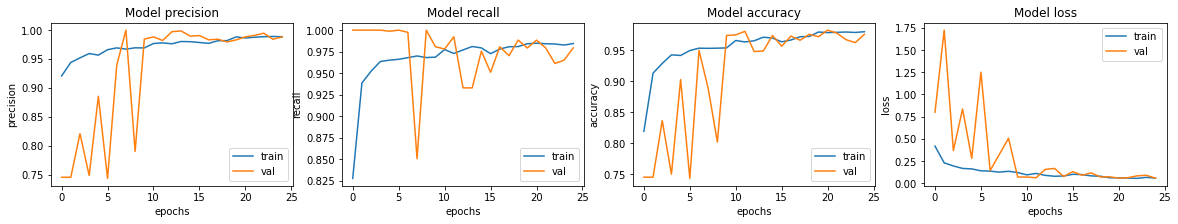

In [32]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# 테스트 데이터 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 69ms/step - loss: 1.1842 - accuracy: 0.8013 - precision: 0.7608 - recall: 0.9949


+ 모든 사람을 대상으로 xray를 촬영하는 것이 아니고 병원에 내방한 환자들 중 의심이 가는 환자들만을 대상으로 xray 사진을 찍게 되기 때문에 폐렴환자의 폐 사진이 폐럼이 없는 사진보다 많다.
+ 때문에 weight balance로 class imbalance를 조정해주지 않을 경우 데이터가 더 많은 pneumonia 사진을 중점으로 학습하게 된다. 따라서 recall은 99%로 높게 나오지만 accuracy는 80%로 낮게 나온다. 
+ 따라서 recall만에 관심이 있는 경우 weigt balance를 진행하지 않고 학습을 하거나 오히려 폐렴 클래스인 1번 클래스에 더 큰 가중치를 주고 진행할 수도 있다. 
+ 하지만 이런 경우 극단적으로 모든 사진을 1로 예측할 경우 false negative가 0이 되며 recall/sensitivity는 100% 을 달성할 수는 있으나 예측모델로서의 가치는 없을 것이다.
+ 아래에서는 imbalance를 처리해주고 학습을 시키도록 한다.

## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.


In [77]:
# optimizer 설정, learning rate 작게 설정
optimizer=tf.keras.optimizers.Adam(1e-4)

# 모델 훈련, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
# 콜백함수 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/chest_xray/models/model'
es = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10),
      tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)]

In [79]:
# model fit : 좌우 반전 없는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=40,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0,
        callbacks=[es]
    )


Epoch 00001: val_loss improved from inf to 0.64354, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00002: val_loss improved from 0.64354 to 0.57570, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00003: val_loss did not improve from 0.57570

Epoch 00004: val_loss improved from 0.57570 to 0.12144, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00005: val_loss improved from 0.12144 to 0.08449, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00006: val_loss did not improve from 0.08449

Epoch 00007: val_loss did not improve from 0.08449

Epoch 00008: val_loss did not improve from 0.08449

Epoch 00009: val_loss did not improve from 0.08449

Epoch 00010: val_loss did not improve from 0.08449

Epoch 00011: val_loss did not improve from 0.08449

Epoch 00012: val_loss improved from 0.08449 to 0.07135, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00013: val_loss did not improve from 0.07135

Epoch 0

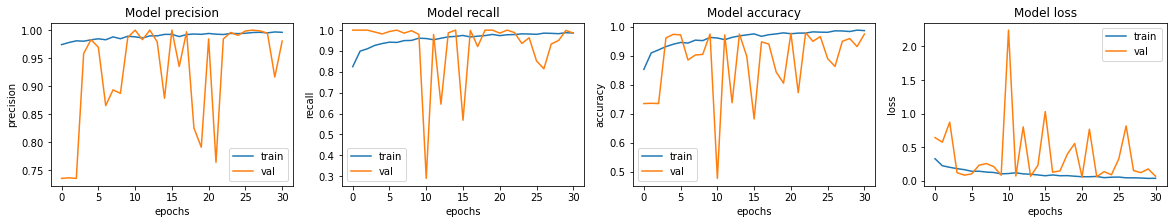

In [80]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [82]:
model.load_weights(checkpoint_dir)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 0.7681 - accuracy: 0.7436 - precision: 0.7106 - recall: 0.9949


+ 학습률을 작게하니 성능이 안좋아졌다. drop out이 섞여 있는데 학습률을 작게 해서 매번 활성 노드 변경 될 때 업데이트가 잘 안되는 걸까. 
+ 기본 학습률로 다시 돌려보기로 한다.
+ early stopping patience는 좀 더 적게 주도록 한다.

In [83]:
# 모델 훈련, gpu 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [84]:
# 콜백함수 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/chest_xray/models/model'
es = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 7),
      tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)]

In [85]:
# model fit : 좌우 반전 없는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=40,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0,
        callbacks=[es]
    )


Epoch 00001: val_loss improved from inf to 0.71493, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00002: val_loss did not improve from 0.71493

Epoch 00003: val_loss improved from 0.71493 to 0.40456, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00004: val_loss improved from 0.40456 to 0.13505, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00005: val_loss did not improve from 0.13505

Epoch 00006: val_loss improved from 0.13505 to 0.07146, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00007: val_loss did not improve from 0.07146

Epoch 00008: val_loss did not improve from 0.07146

Epoch 00009: val_loss improved from 0.07146 to 0.06064, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00010: val_loss did not improve from 0.06064

Epoch 00011: val_loss did not improve from 0.06064

Epoch 00012: val_loss improved from 0.06064 to 0.05854, saving model to /home/ssac7/aiffel/chest_xray/models/mo

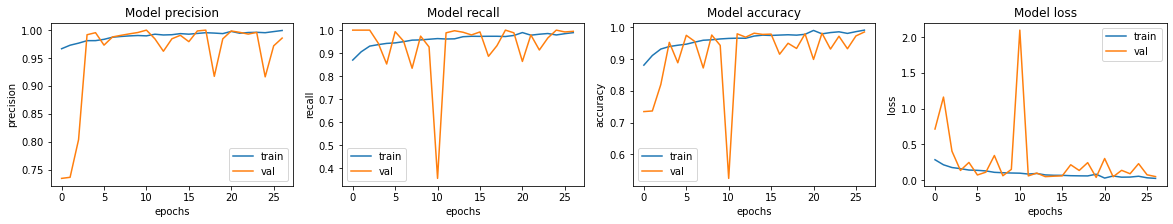

In [86]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [87]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 1.3109 - accuracy: 0.7564 - precision: 0.7196 - recall: 1.0000


In [88]:
model.load_weights(checkpoint_dir)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 0.9905 - accuracy: 0.8173 - precision: 0.7749 - recall: 0.9974


+ 기본 학습률을 사용하는 것이 더 좋은 결과가 나왔다. 학습률을 조금 더 높여보기로 한다.

In [104]:
# 모델 훈련, gpu 사용
optimizer=tf.keras.optimizers.Adam(1e-2)
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [105]:
# 콜백함수 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/chest_xray/models/model'
es = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10),
      tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)]

In [106]:
# model fit : 좌우 반전 없는 데이터
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=40,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        verbose=0,
        callbacks=[es]
    )


Epoch 00001: val_loss improved from inf to 2.79581, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00002: val_loss improved from 2.79581 to 0.93358, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00003: val_loss improved from 0.93358 to 0.63461, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00004: val_loss did not improve from 0.63461

Epoch 00005: val_loss did not improve from 0.63461

Epoch 00006: val_loss improved from 0.63461 to 0.35514, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00007: val_loss improved from 0.35514 to 0.12943, saving model to /home/ssac7/aiffel/chest_xray/models/model

Epoch 00008: val_loss did not improve from 0.12943

Epoch 00009: val_loss did not improve from 0.12943

Epoch 00010: val_loss did not improve from 0.12943

Epoch 00011: val_loss did not improve from 0.12943

Epoch 00012: val_loss did not improve from 0.12943

Epoch 00013: val_loss improved from 0.12943 to 0.11688, sav

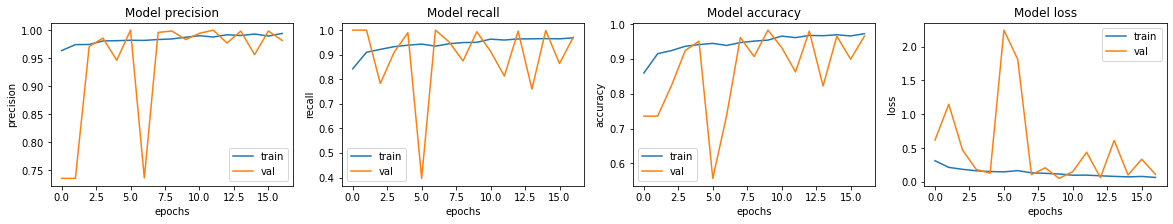

In [92]:
# 결과 확인 precision, recall, accuracy, loss 변화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [93]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 0.5959 - accuracy: 0.8317 - precision: 0.8025 - recall: 0.9692


In [94]:
model.load_weights(checkpoint_dir)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.7403 - accuracy: 0.7804 - precision: 0.7419 - recall: 0.9949
